## Load Data

In [0]:
from google.colab import files

uploaded = files.upload()

for i in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=i, length=len(uploaded[i])))

Saving Tendencias.csv to Tendencias (2).csv
User uploaded file "Tendencias.csv" with length 2803 bytes


## Import Packages

In [0]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.arima_model import ARIMA # For non-seasonal data
import seaborn as sns

plt.style.use('fivethirtyeight')
fig = (12,6)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Cleaning Data
df = pd.read_csv('Tendencias.csv',skiprows=2, index_col='Month')
df.columns = ['pijamas','bikinis']
df.index = pd.to_datetime(df.index)

df.head(2)

,pijamas,bikinis
Month,,
2004-01-01,8,19
2004-02-01,6,19


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196 entries, 2004-01-01 to 2020-04-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   pijamas  196 non-null    int64
 1   bikinis  196 non-null    int64
dtypes: int64(2)
memory usage: 4.6 KB


In [0]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pijamas,196.0,16.581633,6.631585,5.0,12.0,15.0,19.0,44.0
bikinis,196.0,33.821429,12.008277,15.0,24.0,33.0,41.0,100.0


## Visualize Google Trends Data

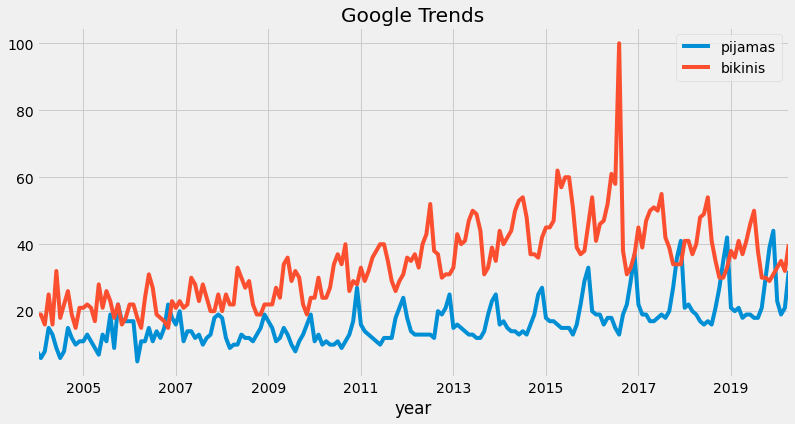

In [0]:
df.plot(figsize=fig)
plt.xlabel('year')
plt.title('Google Trends');

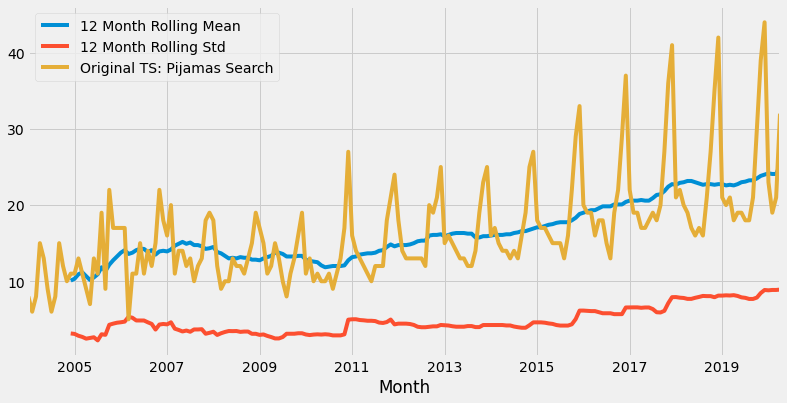

In [0]:
# Working with Pijamas Series
timeseries = df['pijamas']
window=12

plt.figure(figsize=fig)
timeseries.rolling(window).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(window).std().plot(label='12 Month Rolling Std')
timeseries.plot(label='Original TS: Pijamas Search')
plt.legend();

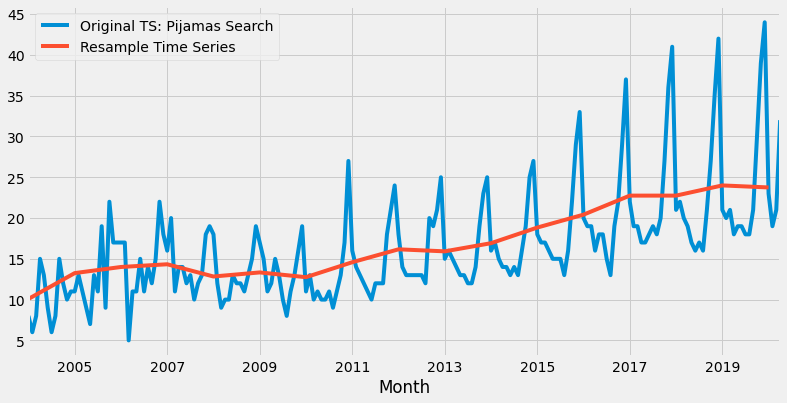

In [0]:
# Resampling
timeseries_resam = timeseries.resample('A').mean()

plt.figure(figsize=fig)
timeseries.plot(label = 'Original TS: Pijamas Search')
timeseries_resam.plot(label='Resample Time Series')
plt.legend();

## Decomposition

<Figure size 432x288 with 0 Axes>

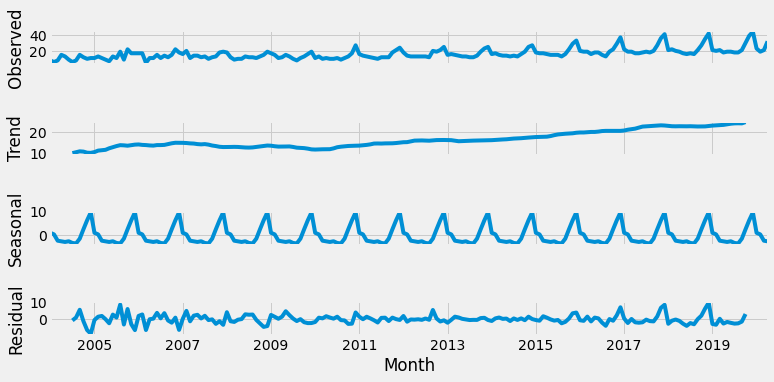

In [0]:
# Decomposition
decomposition = seasonal_decompose(df['pijamas'],freq=window)

fig_ = plt.figure()  
fig_ = decomposition.plot()
fig_.set_size_inches(fig);

## Dickey-Fuller Test

In [0]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [0]:
# Test: Original Time Series
adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.8444347153424413
p-value : 0.9923206019227581
#Lags Used : 13
Number of Observations Used : 182
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## How to make a Time Series Stationary?

There are two major reasons behind non-stationarity of a TS:

1. Trend – varying mean over time. 

2. Seasonality – variations at specific time-frames.

In [0]:
# Cheking Trend
ts_cycle, ts_trend = sm.tsa.filters.hpfilter(timeseries)

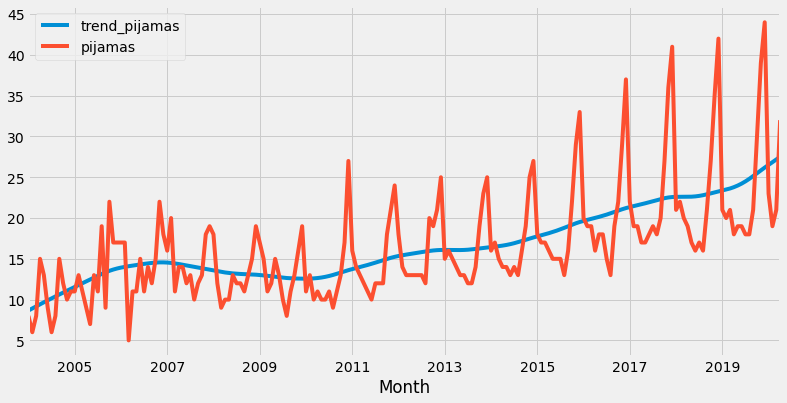

In [0]:
# Plotting Trend
df["trend_pijamas"] = ts_trend
df[['trend_pijamas','pijamas']].plot(figsize=fig);

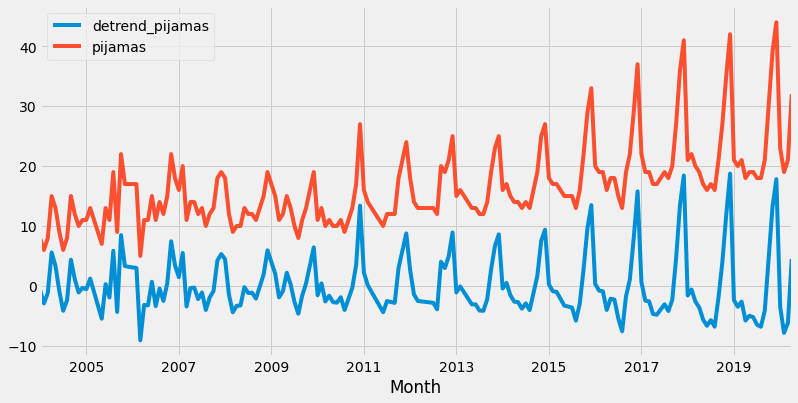

In [0]:
# Plotting Detrinding Serie
df["detrend_pijamas"] = ts_cycle
df[['detrend_pijamas','pijamas']].plot(figsize=fig);

## Differencing

First Difference

In [0]:
df['ts_first_diff'] = timeseries - timeseries.shift(1)
adf_check(df['ts_first_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.8106085284197295
p-value : 2.121057410040237e-09
#Lags Used : 12
Number of Observations Used : 182
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [0]:
df.ts_first_diff.plot(figsize=fig)
plt.title('Firs Difference');

Seasonal Difference

In [0]:
df['ts_seasonal_diff'] = timeseries -  timeseries.shift(window)
adf_check(df['ts_seasonal_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.613946291357494
p-value : 0.00549993427432492
#Lags Used : 12
Number of Observations Used : 171
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


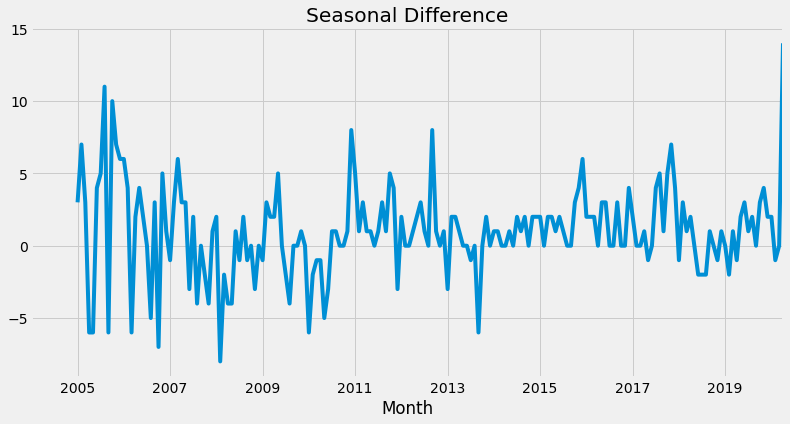

In [0]:
df.ts_seasonal_diff.plot(figsize=fig)
plt.title('Seasonal Difference');

## Autocorrelation and Partial Autocorrelation

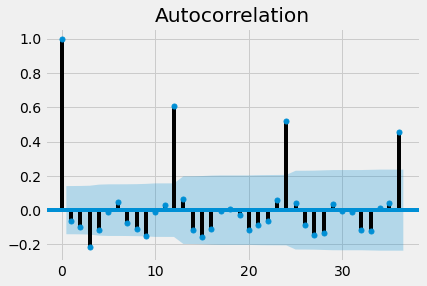

In [0]:
# Autocorrelation Plot
acf_plot = plot_acf(df.ts_first_diff.dropna(),lags=36)

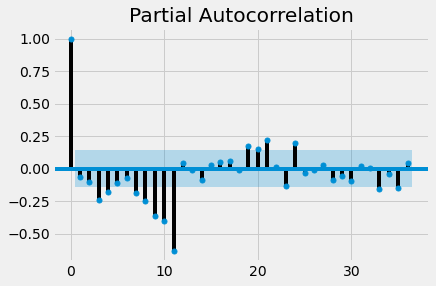

In [0]:
# Partial Autocorrelation Plot
pacf_plot = plot_pacf(df.ts_first_diff.dropna(),lags=36)

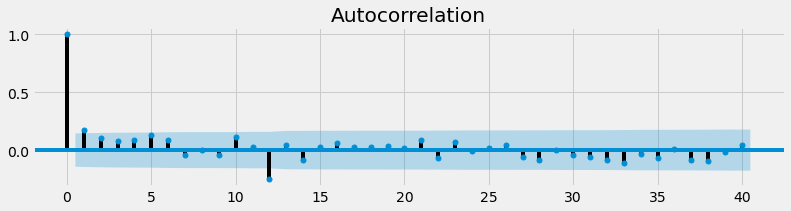

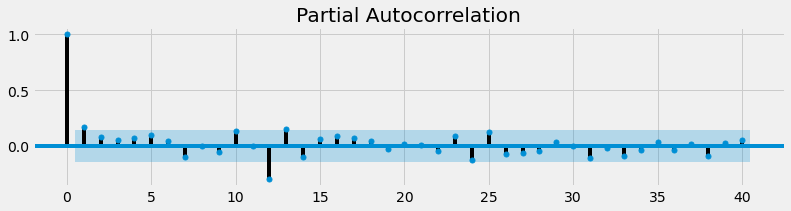

In [0]:
# Plotting Seasonal Autocorrelation

fig1, fig2 = plt.figure(figsize=fig), plt.figure(figsize=fig)
ax1 = fig1.add_subplot(211)
fig_ = sm.graphics.tsa.plot_acf(df.ts_seasonal_diff.dropna(), lags=40, ax=ax1)
ax2 = fig2.add_subplot(212)
fig_ = sm.graphics.tsa.plot_pacf(df.ts_seasonal_diff.dropna(), lags=40, ax=ax2);

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                            pijamas   No. Observations:                  196
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -452.340
Date:                            Mon, 20 Apr 2020   AIC                            914.680
Time:                                    01:13:03   BIC                            930.728
Sample:                                01-01-2004   HQIC                           921.185
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2007      0.076      2.649      0.008       0.052       0.349
ma.L1         -0.9094      0.050   

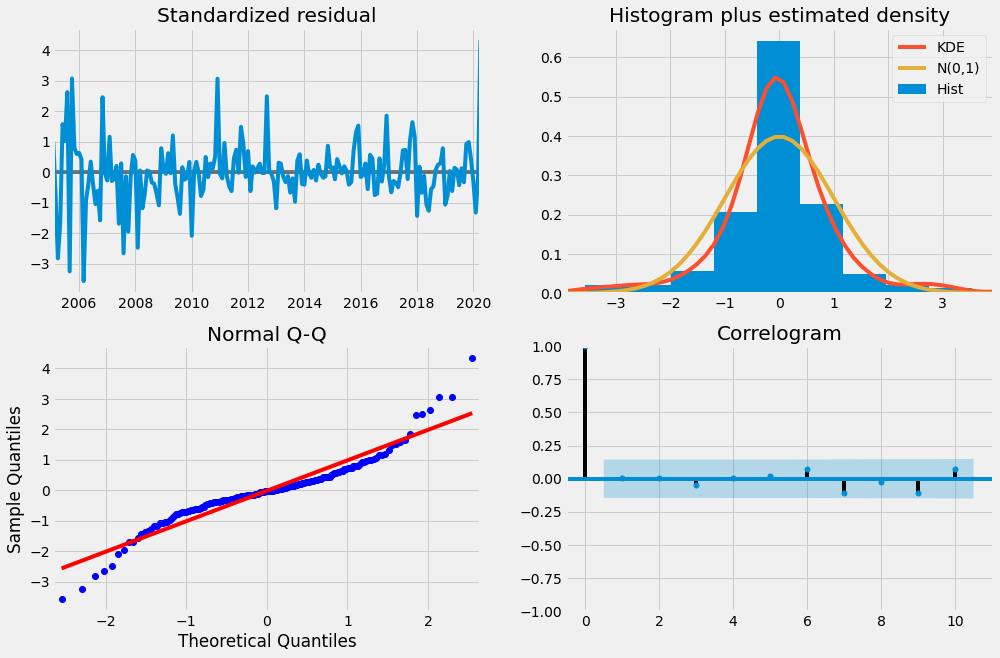

In [0]:
# Seasonal data
# model = sm.tsa.statespace.SARIMAX(timeseries,order=(1,1,1), seasonal_order=(1,1,1,12))
model = SARIMAX(timeseries,order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

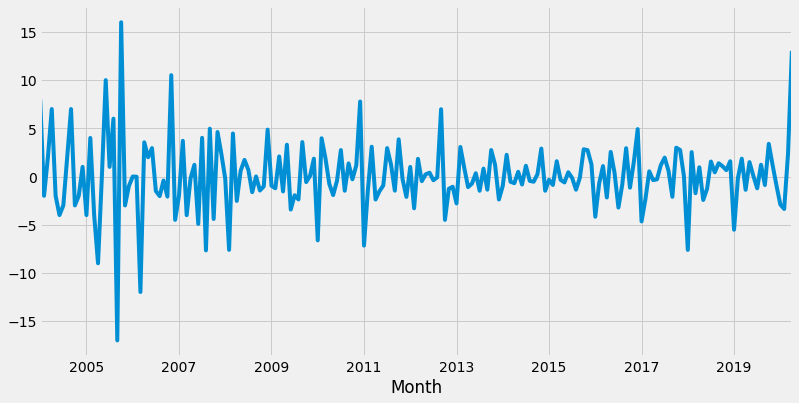

In [0]:
# Residuals
results.resid.plot(figsize=fig);

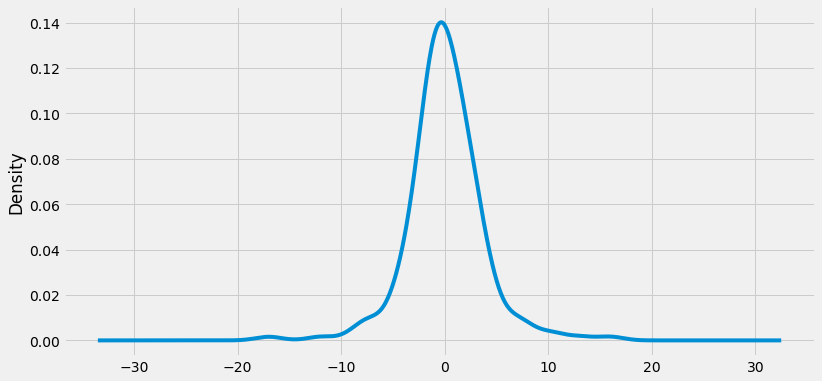

In [0]:
# Distribution of Residuals
results.resid.plot(kind='kde',figsize=fig);

## Forecasting

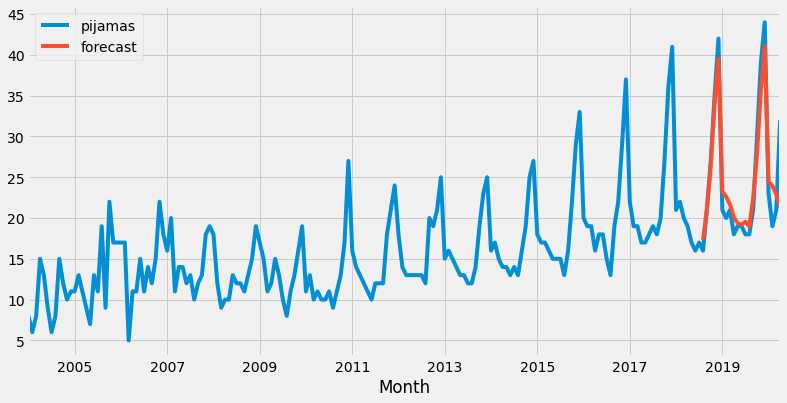

In [0]:
df['forecast'] = results.predict(start = 175, end= 196, dynamic= True)  
df[['pijamas','forecast']].plot(figsize=fig);

In [0]:
df.tail(2)

,pijamas,bikinis,trend_pijamas,detrend_pijamas,ts_first_diff,ts_seasonal_diff,forecast
Month,,,,,,,
2020-03-01,21,32,27.175303,-6.175303,2.0,0.0,22.870156
2020-04-01,32,40,27.507092,4.492908,11.0,14.0,21.362318


In [0]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24)]
future_dates

[Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-12-01 00:00:00'),
 Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-05-01 00:00:00'),
 Timestamp('2021-06-01 00:00:00'),
 Timestamp('2021-07-01 00:00:00'),
 Timestamp('2021-08-01 00:00:00'),
 Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timestamp('2021-12-01 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-02-01 00:00:00'),
 Timestamp('2022-03-01 00:00:00')]

In [0]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [0]:
future_df = pd.concat([df,future_dates_df])

In [0]:
future_df.tail()

,pijamas,bikinis,trend_pijamas,detrend_pijamas,ts_first_diff,ts_seasonal_diff,forecast
2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


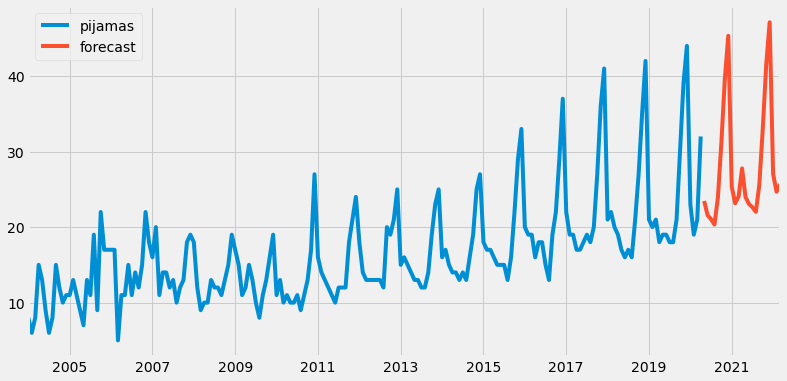

In [0]:
future_df['forecast'] = results.predict(start = 196, end = 220, dynamic= True)  
future_df[['pijamas', 'forecast']].plot(figsize=fig);